#Ультра-про задание

В данном задании нужно обучить алгоритм Преймущественного Актёра Критика (А2С) на любой среде из библиотеки `gym` либо `ViZDoom`, которой не было в этом занятии.

Как вариант, предлагается обучить алгоритм на среде `defend_the_center`, которая была в первом занятии по обучению с подкреплением (занятие: `Введение в обучение с подкреплением, алгоритм Q-обучение`). Таким образом можно будет сравнить работоспособность обеих алгоритмов на данной среде.


Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы которые упомянаются в официальной документации.

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

Затем, устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории. Нужно указать версию 1.1.9 чтобы библиотека успешно установилась в среде колаба.

In [ ]:
#Обычно уходит 5-10 минут на установку этой библиотеки.
!pip install vizdoom==1.1.9

     |████████████████████████████████| 15.0 MB 22.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.9-py3-none-any.whl size=14084059 sha256=cb7b2340578dfee56b653a175d06caded6497bd110cbc8cd49b27d79f14d733e
  Stored in directory: /root/.cache/pip/wheels/89/75/34/2c03a5cc9d572ad08bed39e67bf0da279f63b03864a3aa2c66
Successfully built vizdoom


Cкачиваем все нужные файлы для среды ViZDoom.

In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /content/ViZDoom/ #Разархивируем файлы

Не забываем подключить гугл-диск.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Импортируем библиотеки, которые будем использовать.

In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2056192/45929032 bytes (4.5%)3915776/45929032 bytes (8.5%)5734400/45929032 bytes (12.5%)8445952/45929032 bytes (18.4%)10502144/45929032 bytes (22.9%)13008896/45929032 bytes (28.3%)14983168/45929032 bytes (32.6%)16531456/45929032 bytes (36.0%)18677760/45929032 bytes (40.7%)20398080/45929032 bytes (44.4%)22937600/45929032 bytes (49.9%)24920064/45929032 bytes (54.3%)270

## Создадим сеть актёр-критик

In [ ]:
# Функция для создания нейронной сети принимает на вход размер картинок, количество возможных действий, и шаг обучения.
def Make_A2C(input_shape, action_size, learning_rate):
  state_input_layer = Input(input_shape)                          #Входная размерность (96, 96, 4)
  agent_input_layer = Input((2,))                                 #Входной слой куда подается количество оставшихся потронов + здоровье

  x = Conv2D(16, 5, activation = 'elu')(state_input_layer) #Выходная размерность (92, 92, 16)
  x = MaxPooling2D(4)(x)                                   #Выходная размерность (23, 23, 16)
  x = Conv2D(32, 3, activation = 'elu')(x)                 #Выходная размерность (21, 21, 32)
  x = MaxPooling2D(3)(x)                                   #Выходная размерность (7, 7, 32)
  x = Conv2D(64, 3, activation = 'elu')(x)                 #Выходная размерность (5, 5, 64)
  x = GlobalMaxPooling2D()(x)                              #Выходная размерность (64)
  x = Dense(128, activation = 'elu')(x)                    #Выходная размерность (128)
  actor_output = Dense(action_size, activation = 'softmax', name = 'actor_output')(x)  #Выходной слой актёра - выходная размерность (action_size)
  critic_output = Dense(1, name = 'critic_output')(x)                                  #Выходной слой критика - выходная размерность (1)

  model = Model([state_input_layer, agent_input_layer], [actor_output, critic_output])   #Создаем объект модели

  optimizer = RMSprop(lr = learning_rate) #Практика показывает что RMSprop хороший оптимизатор для обучения с подкреплением, однако можно использовать adam.
  model.compile(loss = {'actor_output':'sparse_categorical_crossentropy', 'critic_output':'mse'}, optimizer = optimizer, loss_weights=[1, 5]) #Компилируем модель с функции ошибки mse и заданным оптимизатором.

  return model   #Функция возвращает готовую, компилированную модель.

Задаем гиперпараметры.

Как мы видим, здесь алгоритмов относительно немного.

In [ ]:
gamma = 0.95           #Гамма (параметр для передачи наград между состояний)
learning_rate = 1e-3   #Задаем шаг обучения

image_width = 96   #Ширина картинки (кадра)
image_height = 96  #Высота картинки (кадра)
num_frames = 4     #Количество последовательных кадров в одном состоянии (используется позже)
#Размерность каждого состояния будет размер картинки (её высота и ширина) на количество последовательных кадров
state_shape = (image_width, image_height, num_frames) 


Создадим функцию, которая будет обрабатывать изображения

In [ ]:
def preprocess_frame(frame):
  frame = np.rollaxis(frame, 0, 3) #Сначала нужно предобрадотать картинку чтобы размер поменялся с (3, width, height) на (width, height, 3).
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) #Меняем размерность картинки на (64 х 64)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Делаем изображение чёрно-белым

  return frame.reshape(image_width, image_height, 1)/255 #Делаем решейп, и возврашаем предобработанную картинку, нормализуем

Также создаем функцию для предобработки наград. Награды могут назначаться автоматический, но также можно и крайней желательно регулировать вручную. Однозначный плюс среды ViZDoom - мы можем легко менять логику, с которой назначаются награды за различные события в среде (например: убил врага = 100 очков награды).

Наша функция будет принимать информацию из игры на текущее и предидущее состояние на вход, а также булевое значение - если кадр является последним в эпизоде. В соответствии с этой информацией мы можем задавать награду r(s, a), по которой наш алгоритм будет обучаться.

In [ ]:
#previous_misc - информация о игровой среде на предидущий кадр (количество убитых врагов, патроны, и здоровие)
#current_misc - информация о игровой среде на текущий кадр (количество убитых врагов, патроны, и здоровие)
#episode_done - булевое значение, которое говорит если кадр является последним в эпизоде.

#misc[0] - количесто убитых врагов, misc[1] - патроны, misc[2] - здоровие
#########################################!!!ВАЖНО!!!#########################################
#информация которая содержится в массивах previous_misc и current_misc а также индексы могут отличаться в зависимости от конкретного сценария из ViZDoom.
#Эту информацию можно посмотреть или поменять в соответствующих .cfg файлах, с помощью которого строится среда. 
#Данная функция заточена под сценарий который рассматривается на уроке - но ниже представленную функцию нужно поменять при использовании других сценарий.

def get_reward(previous_info, current_info, episode_done):
  reward = 0     #Инициализируем награду как 0
  if episode_done:                          #Если кадр является последним в игре, ставим награду как -0.1 и возвращаем её (агент умер)
    reward = -0.1
    return reward
  if current_info[0] > previous_info[0]:   #Если убили врага в кадре, увеличиваем награду на 1
    reward += 1
  if current_info[1] < previous_info[1]:   #Если потеряли здоровие, уменьшаем награду на 0.1
    reward -= 0.1
  if current_info[2] < previous_info[2]:   #Если использовали патрон, уменьшаем награду на 0.1
    reward -= 0.1

  return reward  #Возвращаем подсчитанную награду

Создадим функцию, по которой агент будет принимать действие.

In [ ]:
def choose_action(environment_state, agent_state, train_mode = True):      
  environment_state, agent_state = np.expand_dims(environment_state, axis = 0), np.expand_dims(agent_state, axis = 0) #Добавляем размерность к входным данным
  
  #Из предикта модели принимаем вероятности для действий И предсказание критика (предсказание критика нам не нужно, его принимаем только чтобы избежать ошибку)
  actor_probs, critic_value = model.predict([environment_state, agent_state])      

  if train_mode: #Если агент обучается
    action_index = np.random.choice(action_size, p = actor_probs.flatten()) #Выбираем индекс действия, в соответствии с предсказанным вероятностям  
  else: #Иначе (агент уже используется в тестовом режиме)
    action_index = np.argmax(actor_probs) #Выбираем индекс действия по максимальной вероятностью   
  return action_index #Возвращаем выбранный индекс действия     

Создадим функцию, в которой сеть будет обчаться.

In [ ]:
#Создаем функцию для обучения модели.
def train(episode_environment_states, episode_agent_states, episode_actions, episode_rewards):
  episode_environment_states = np.array(episode_environment_states) #Переводим список состояний среды в numpy-массив
  episode_agent_states = np.array(episode_agent_states)             #Переводим список состояний агента в numpy-массив
  episode_actions = np.array(episode_actions)                       #Переводим список индексов действий в numpy-массив

  rewards = preprocess_rewards(episode_rewards)    #Предобрабатываем награды (также как это делалось в занятии по градиентной политике)
  probs, values = model.predict([episode_environment_states, episode_agent_states])  #Актёр нейронной сети предсказывает вероятность действий. Критик предсказывает ценность состояния. Критик нужен лишь для обучение актёра. 

  advantages = rewards - values.flatten()          #Применяем уравнение для вычисления преймуществ - по определению A(s, a) = Q(s, a) - V(s)

  #Тут всё довольно просто - для акрёта, мы используем sample_weight = advantages вместо rewards (то есть обучаем не на наградах, а на преймуществах).
  #Критик всего лишь обучается предсказывать правильную ценность состояния. sample_weights не нужны для критика, по этому ставим все веса сэмплов для критика как единицы.
  model.train_on_batch([episode_environment_states, episode_agent_states], [episode_actions, rewards], sample_weight = {'actor_output':advantages, 'critic_output':np.ones(advantages.shape)})

Также не забудим про функцию, которая обрабатывает награды. В данной среде, желательно использовать функцию для непрерывных наград.

In [ ]:
#Функция для предобработки наград
def preprocess_rewards(rewards):
  processed_rewards = np.zeros_like(rewards, dtype = np.float32) #Сначала создаем массив из нулей с той же размерностью, как в массиве наград 
  running_add = 0 #Переменная которая используется для предобработки наград
  for i in reversed(range(0, len(rewards))): #В цикле итерируем через индексы списка наград в обратном порядке
    running_add = running_add * gamma + rewards[i] # Составляем новую награду, в соответствии с "псевдо"-уравнением Бэллмена
    processed_rewards[i] = running_add #Записываем награду в ранее созданный массив
  return processed_rewards #Возвращаем массив наград

Следующая функция очень простая - она предобрабатывает числа из состояния агента, чтобы они были нормированными.

In [ ]:
#Функция для предобработки прочих чисел из игровой среды
def preprocess_agent_state(agent_state):
  return agent_state[1:]/50 - 1 #Просто делим на 50 и вычитать 1, чтобы они не имели слишком большую величину (берём только последние два элемента, т.к.первый элемент содержит количество убитых врагов и не является нужным)

В конце создадим функцию для визуализации результатов агента на каждый эпизод.

Функция будет отображать награду, скользящее среднее награды (за 20 эпизодов), количество убитых врагов, а также количество оставшихся патронов в конце каждого эпизода.

Из-за многих рандомных факторов в среде и в самом алгоритме, награда и длина эпизода будет сильно варьировать при обучении, что приведёт к сложностям при нахождении какой-либо тенденции. По этому, мы также будем считать скользящие средние от всех анализируемых данных. Скользящее среднее за большое количество эпизодов (в данном случае 50) является гораздо более надёжной и хорошей метрикой для обнаружения какой-либо тенденции в обучении.

Для подсчета скользящего среднего, используется функция свёртки.

In [ ]:
#Создаем функцию для визуализации результата
def show_scores(scores, killcount, ammo):
  output.clear() #Удаляем предидущий вывод ячейки
  #Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов) 
  fig, axes = plt.subplots(1, 2, figsize = (20, 8)) #Делаем размер графика большим

  axes[0].plot(scores, label = "Награда за эпизод")                          #Устанавливаем большой размер полотна
  axes[0].plot(moving_average(scores), label = "Скользящее среднее награды") #Отрисовываем скользящие средние награды
  axes[0].set_xlabel("Итерация", fontsize = 16)                              #Добавляем лейблы осей
  axes[0].set_ylabel("Награда", fontsize = 16)
  axes[0].legend()                               #Добавляем легенду к графику

  axes[1].plot(killcount, 'red', linestyle = '--', label = "Количество убитых врагов (сумма за 10 эпизодов)")                                     #Отрисовываем количество убитых врагов
  axes[1].plot(moving_average(killcount), 'black', label = "Количество убитых врагов (скользящее среднее за 10 итераций)") #Отрисовываем количество убитых врагов (скользящее среднее)
  axes[1].plot(ammo, 'green', linestyle = '--', label = "Осталось патронов (сумма за 10 эпизодов)")                                               #Отрисовываем количество оставшихся патронов
  axes[1].plot(moving_average(ammo), 'blue', label = "Осталось патронов (скользящее среднее за 10 итераций)")              #Отрисовываем количество оставшихся патронов (скользящее среднее)
  axes[1].set_xlabel("Итерация", fontsize = 16)  #Добавляем лейблы осей
  axes[1].set_ylabel("Значение", fontsize = 16)
  axes[1].legend()                               #Добавляем легенду к графику

  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

В данном уроке мы будем обучать бота играть в сценарий, который называется "защищай центр" (defend the center). Игрок находиться в центре большой, круглой комнате, где появляются различные враги.

У игрока есть пистолет, 26 патронов, и он может совершать три действия (повернуть влево, повернить вправо, выстрелить). Игра заканчивается когда игрока убивают монстры, что по любому произойдёт рано или поздно (патроны закончаться, игрок не может убегать, по этому его убьют). Цель игрока - убить максимальное количество монстров до того, как закончаться патроны. В идеале игрок сможет убить 26 монстров.

Сначала мы создадим нашу игровую среду, а также инициализируем нашу нейронную сеть.

In [ ]:
game = DoomGame() #Инициализируем среду.
game.load_config("/content/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий "защищай центр"
game.set_screen_resolution(ScreenResolution.RES_160X120) #Устанавливаем размер кадров среды (будет 160 х 120)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()                 #Извлекаем количество возможных уникальных действий

model = Make_A2C(state_shape, action_size, learning_rate)   #Создаем основную модель (будет обучаться)

frames_per_action = 4  #Установим количество кадров за каждое действие. Нам не нужен каждый кадр, 
                       #по этому будем совершать действие и брать новое состояние лишь раз в 4 кадра.

Алгоритмы RL обучаются долго, и часто одной сессии колаба не хватает. В следующим блоке можно загружать веса обученной модели, а также полезные статистики чтобы продолжить обучение. 

Если обучение начинается с нуля то мы просто инициализируем списки где будет храниться полезная статистика.

In [ ]:
load_pretrained = True #Решаем, если мы обучаем можель с нуля или продолжаем предидущую сессию обучение.

#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой модели
if load_pretrained:
  model.load_weights('/content/drive/My Drive/pretrained_networks/defend_the_center_A2C_model.h5')
  #Также загружаем ранее сохраненные статистики из pickle файла.
  with open('/content/drive/My Drive/pretrained_networks/defend_the_center_A2C_model.txt', 'rb') as f:
    record_rewards, record_kills, record_ammos, episode_number, timestep = pickle.load(f)

#Иначе мы просто инизиализируем списки, в которых будет храниться статистика о работе агента.
else:
  record_rewards = []          #Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            #Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            #Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     #Инициализицем номер эпизода как 1
  timestep = 0           #Инициализируем номер шага как 0

## Дальше мы создаем игровой цикл, в котором агент будет играть в игру и обучаться.

Данная игра и алгоритм относительно простые, и в итоге обучается примерно 10 часов на процесорре в колабе (результаты видны после ~5 часов). Другие алгоритмы, или даже тот же алгоритм в более сложной среде может обучаться намного дольше.

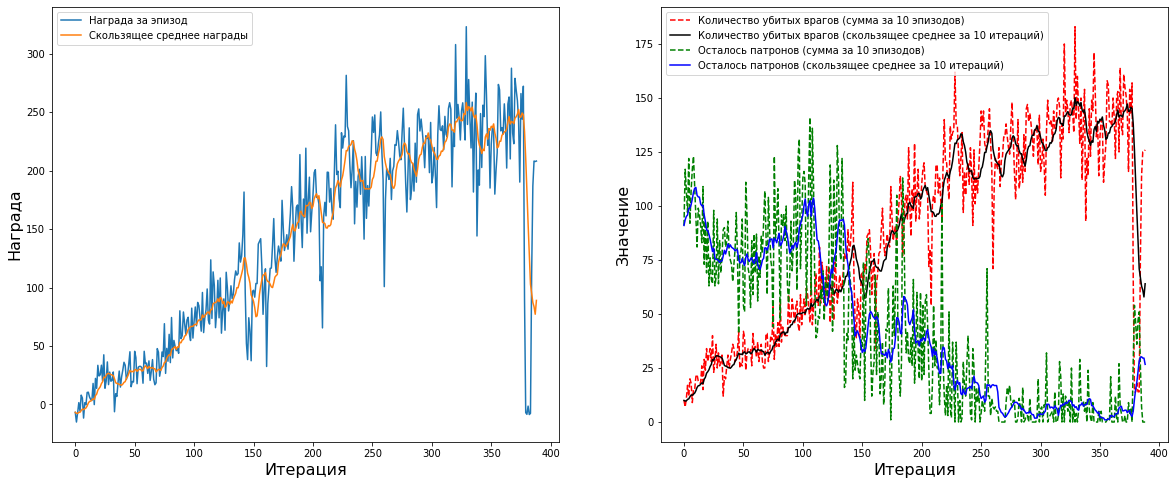

Статистика успешно сохранена.
Закончился 3890-й эпизод. Количество убитых врагов: 14.0, количество оставшихся патронов: 0.0
Закончился 3891-й эпизод. Количество убитых врагов: 13.0, количество оставшихся патронов: 0.0
Закончился 3892-й эпизод. Количество убитых врагов: 20.0, количество оставшихся патронов: 0.0
Закончился 3893-й эпизод. Количество убитых врагов: 19.0, количество оставшихся патронов: 0.0
Закончился 3894-й эпизод. Количество убитых врагов: 19.0, количество оставшихся патронов: 0.0
Закончился 3895-й эпизод. Количество убитых врагов: 15.0, количество оставшихся патронов: 0.0


In [ ]:
#Обучение будет происходить в бесконечном цикле (мы будет прерывать обучение вручную, когда захотим)
game.new_episode()                        #Генерим новый эпизод
game_data = game.get_state()             #Извлекаем первый кадр (это ещё не полноценное состояние)
current_info = game_data.game_variables  #Извлекаем информацию о игре (кол. убитых врагов, патроны, здоровие)
previous_info = current_info              #Записываем информацию о текущем моменте как 'предидущий' момент (чтобы потом могли сравнить разницу)

frame = game_data.screen_buffer                                                      #Извлекаем кадр из игры (160 x 120)
processed_frame = preprocess_frame(frame)                                            #Предобрабатываем кадр в чёрно-белый (размер 96 х 96)
environment_state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 4 раза.

interval_reward = 0  #Инициализируем награду за интервал (10 эпизодов) как 0
interval_kills = 0   #Инициализируем количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   #Инициализируем количество оставшихся патронов (10 эпизодов) как 0

episode_environment_states = []  #Создаем список, куда записываем все состояния среды
episode_agent_states = []        #Создаем список, куда записываем все состояния агента
episode_actions = []             #Создаем список, куда записываем все действия
episode_rewards = []             #Создаем список, куда записываем все награды

while True:
  timestep += 1 #Увеличиваем номер шага на 1
  action_index = choose_action(environment_state, preprocess_agent_state(previous_info)) #Извлекаем индекс награды и новое значение эпсилон
  action_onehot = to_categorical(action_index)                              #Приводим награду в onehot массив
  game.set_action(action_onehot.tolist())                                   #Подаем действие в игровую среду в качестве списка 
  game.advance_action(frames_per_action)                                    #Игра продвигается на 4 кадра (значение frames_per_action)

  game_data = game.get_state()     #Предобрабатываем кадр в чёрно-белый (размер 96 х 96 x 1)

  episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

  episode_environment_states.append(environment_state)               #Добавляем состояние среды в соответствующий список
  episode_agent_states.append(preprocess_agent_state(previous_info)) #Добавляем состояние агента в соответствующий список
  try:
    current_info = game_data.game_variables   #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    frame = game_data.screen_buffer           #Извлекаем новый кадр из игры
  except:
    current_info = previous_info
  processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 96 х 96 х 1)   
  environment_state = np.append(processed_frame, environment_state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

  environment_reward = game.get_last_reward()                           #Извлекаем нагаду за шаг из среды (логика, которую не можем менять)
  custom_reward = get_reward(previous_info, current_info, episode_done) #Извлекаем нагаду за шаг из самописный функции (самописная награда, значит можем менять логику)
  reward = environment_reward + custom_reward #Общая награда - это сумма награды из среды и самописной награды

  episode_actions.append(action_index)                               #Добавляем индекс действия в соответствующий список
  episode_rewards.append(reward)                                     #Добавляем полученную награду в соответствующий список

  if episode_done: #Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
    print(f"Закончился {episode_number}-й эпизод. Количество убитых врагов: {current_info[0]}, количество оставшихся патронов: {current_info[1]}")
    episode_number += 1   #Увеличиваем номер эпизода на 1
    interval_kills += current_info[0] #Подсчитываем количество убитых врагов
    interval_ammos += current_info[1] #Подсчитываем количество оставщихся патронов

    train(episode_environment_states, episode_agent_states, episode_actions, episode_rewards) #Обучаем нейронную сеть на собранных данных

    episode_environment_states = []   #Создаем список, куда записываем все состояния среды
    episode_agent_states = []         #Создаем список, куда записываем все состояния агента
    episode_actions = []              #Создаем список, куда записываем все действия
    episode_rewards = []              #Создаем список, куда записываем все награды

    #Чтобы не собирать слишком много данных и чтобы данные было удобно отоброжать на графике, мы записываем результаты лишь раз в 10 эпизодов.
    if episode_number % 10 == 0 and episode_number > 0: #Записываем результат раз в 10 эпизодов
      record_rewards.append(interval_reward)            #Добавляем награду в список всех наград
      record_kills.append(interval_kills)  #Добавляем количество убитых врагов
      record_ammos.append(interval_ammos)  #Добавляем количество неиспользованых патронов
      show_scores(record_rewards, record_kills, record_ammos)  #Записываем результаты в графики
      model.save_weights('/content/drive/My Drive/pretrained_networks/defend_the_center_A2C_model.h5') #Сохраняем веса модели
      with open('/content/drive/My Drive/pretrained_networks/defend_the_center_A2C_model.txt', 'wb') as f:  #Записываем статистику в файл через библиотеку pickle
        pickle.dump([record_rewards, record_kills, record_ammos, episode_number, timestep], f) 
      print("Статистика успешно сохранена.")

      interval_reward, interval_kills, interval_ammos = 0, 0, 0 #Заново инициализируем значения статистики для интервала в 10 эпизодов

    game.new_episode()                     #Затем необходимо начать новый эпизод игры
    game_data = game.get_state()           #Извлекаем новое состояние игрык

  interval_reward += reward #Добавляем награду в переменную для статистики

  previous_info = current_info    #Запонимаем предидущию информацию

## Создаем видео с игрой агента

In [ ]:
video_frames = [] #Создаем список куда будем записывать кадры

game = DoomGame() #Инициализируем среду.
game.load_config("/content/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий "защищай центр"
game.set_screen_resolution(ScreenResolution.RES_640X480) #Устанавливаем размер кадров среды (будет 160 х 120)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()                 #Извлекаем количество возможных уникальных действий

model = Make_A2C(state_shape, action_size, learning_rate)   #Создаем основную модель (будет обучаться)

frames_per_action = 4  #Установим количество кадров за каждое действие. Нам не нужен каждый кадр, 
                       #по этому будем совершать действие и брать новое состояние лишь раз в 4 кадра.

game = DoomGame() #Инициализируем среду.
game.load_config("/content/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий "защищай центр"
game.set_screen_resolution(ScreenResolution.RES_640X480) #Устанавливаем размер кадров среды (будет 640 х 480)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

#Обучение будет происходить в бесконечном цикле (мы будет прерывать обучение вручную, когда захотим)
game.new_episode()                #Генерим новый эпизод
game_data = game.get_state()      #Извлекаем первый кадр (это ещё не полноценное состояние)
info = game_data.game_variables   #Извлекаем информацию о игре (кол. убитых врагов, патроны, здоровие)

frame = game_data.screen_buffer                                                      #Извлекаем кадр из игры (640 x 480)
processed_frame = preprocess_frame(frame)                                            #Предобрабатываем кадр в чёрно-белый (размер 96 х 96)
environment_state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 4 раза.

episode_done = False #Создаем переменную, которая указывает что эпизод пока не завершен

while not episode_done: #Запускаем цикл до конца эпизода
  timestep += 1 #Увеличиваем номер шага на 1
  action_index = choose_action(environment_state, preprocess_agent_state(info), train_mode = False) #Извлекаем индекс награды и новое значение эпсилон
  action_onehot = to_categorical(action_index)                                                               #Приводим награду в onehot массив
  game.set_action(action_onehot.tolist())                                                                    #Подаем действие в игровую среду в качестве списка 
  game.advance_action(frames_per_action)                                                                     #Игра продвигается на 4 кадра (значение frames_per_action)

  game_data = game.get_state()     #Предобрабатываем кадр в чёрно-белый (размер 96 х 96 x 1)

  episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

  try:
    info = game_data.game_variables   #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    frame = game_data.screen_buffer           #Извлекаем новый кадр из игры
  except:
    continue
  video_frames.append(np.rollaxis(frame, 0, 3)) #Добавляем кадр в список кадров
  processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 96 х 96 х 1)   
  environment_state = np.append(processed_frame, environment_state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

##Записываем результат в видео

У нас есть массив кадр, нам нужно конвертировать его в видео. Для этого мы используем библиотеку cv2.

In [ ]:
 #Создаем объект для воспроизведениед видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (640, 480)) #Чем больше кадров в секунду, тем быстрее видео будет проигрываться
for i in range(len(video_frames)):   #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR)
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()   #Закрываем объект для создания видео

## Отображаем видео в колабе

Для этого мы снова обратимся к библиотеки moviepy. Конкретно мы будем использовать функцию VideoFileClip для воспроизведения видео.

In [ ]:
path="/content/episode.avi" #Указываем путь к видео

clip=VideoFileClip(path)    #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)
clip.ipython_display(width=640, maxduration = 40) #Отображаем видео в колабе